In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from wordcloud import WordCloud
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
import warnings
warnings.filterwarnings('ignore')

In [2]:
data=pd.read_csv('C:/Users/Biranchi/Desktop/Internship/Projects/Project_2/messages.csv')
data

,subject,message,label
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0
1,NaN,"lang classification grimes , joseph e . and ba...",0
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0
3,risk,a colleague and i are researching the differin...,0
4,request book information,earlier this morning i was on the phone with a...,0
...,...,...,...
2888,love your profile - ysuolvpv,hello thanks for stopping by ! ! we have taken...,1
2889,you have been asked to join kiddin,"the list owner of : "" kiddin "" has invited you...",1
2890,anglicization of composers ' names,"judging from the return post , i must have sou...",0
2891,"re : 6 . 797 , comparative method : n - ary co...",gotcha ! there are two separate fallacies in t...,0


In [3]:
print("Shape of the data is: ",data.shape)

Shape of the data is:  (2893, 3)


In [4]:
#Checking data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2893 entries, 0 to 2892
Data columns (total 3 columns):
subject    2831 non-null object
message    2893 non-null object
label      2893 non-null int64
dtypes: int64(1), object(2)
memory usage: 67.9+ KB


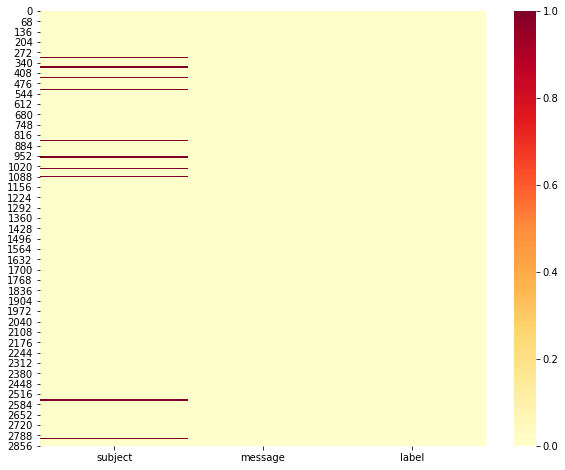

In [5]:
nans=data.isna()
plt.figure(figsize=(10,8))
sns.heatmap(nans,cmap='YlOrRd')

In [6]:
#Checking nan values
data.isnull().sum()

subject    62
message     0
label       0
dtype: int64

In [7]:
#In 62 observations subject is missing

In [8]:
#Statistical Summary
data.describe(include='all')

,subject,message,label
count,2831,2893,2893.000000
unique,2613,2859,NaN
top,sociolinguistics,this is not spam ; you are receiving this mess...,NaN
freq,8,5,NaN
mean,NaN,NaN,0.166263
std,NaN,NaN,0.372381
min,NaN,NaN,0.000000
25%,NaN,NaN,0.000000
50%,NaN,NaN,0.000000
75%,NaN,NaN,0.000000


In [9]:
data.label.value_counts()

0    2412
1     481
Name: label, dtype: int64

In [10]:
#Checking percentages of spam and ham
print("Ham: ",round(len(data[data.label==0])/len(data.label),2)*100," %")
print("Spam: ",round(len(data[data.label==1])/len(data.label),2)*100," %")

Ham:  83.0  %
Spam:  17.0  %


In [11]:
#Subject may be same but we drop the columns having same message
data.message.drop_duplicates(inplace=True)
data.shape

(2893, 3)

In [12]:
#Treating nan by back fill
data['subject'].fillna(method='bfill',inplace=True)

In [13]:
data.isna().sum()

subject    0
message    0
label      0
dtype: int64

In [14]:
#adding subject and message length column
data['sub_len']=data['subject'].str.len()
data['msg_len']=data['message'].str.len()
data.head()

,subject,message,label,sub_len,msg_len
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0,39,2856
1,query : letter frequencies for text identifica...,"lang classification grimes , joseph e . and ba...",0,50,1800
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0,50,1435
3,risk,a colleague and i are researching the differin...,0,4,324
4,request book information,earlier this morning i was on the phone with a...,0,24,1046


In [15]:
#Converting to Lower case
data['subject']=data['subject'].str.lower()
data['message']=data['message'].str.lower()

In [16]:
#Removing Stopwords from both the columns
stop_words=stopwords.words('english')

data['subject']=data['subject'].apply(lambda x: ' '.join(
word for word in x.split() if word not in stop_words))

data['message']=data['message'].apply(lambda x: " ".join(
word for word in x.split() if word not in stop_words))

In [17]:
#Removing punctuations
data.subject=data.subject.str.replace(r'[^\w\d\s]', " ")

data.message=data.message.str.replace(r'[^\w\d\s]'," ")

data.head()

,subject,message,label,sub_len,msg_len
0,job posting apple iss research center,content length 3386 apple iss research cen...,0,39,2856
1,query letter frequencies text identification,lang classification grimes joseph e barbar...,0,50,1800
2,query letter frequencies text identification,posting inquiry sergei atamas satamas umab...,0,50,1435
3,risk,colleague researching differing degrees risk p...,0,4,324
4,request book information,earlier morning phone friend mine living south...,0,24,1046


In [18]:
#Removing more than one leading and trailing spaces
data.subject=data.subject.str.replace(r'^s+|s+?$', " ")

data.message=data.message.str.replace(r'^s+|s+?$', " ")

#Removing leading and trailing tabs

data.subject=data.subject.str.replace(r'^t+|t+?$', " ")

data.message=data.message.str.replace(r'^t+|t+?$', " ")

data.head()

,subject,message,label,sub_len,msg_len
0,job posting apple iss research center,content length 3386 apple iss research cen...,0,39,2856
1,query letter frequencies text identification,lang classification grimes joseph e barbar...,0,50,1800
2,query letter frequencies text identification,posting inquiry sergei atamas satamas umab...,0,50,1435
3,risk,colleague researching differing degrees risk p...,0,4,324
4,request book information,earlier morning phone friend mine living south...,0,24,1046


In [19]:
#Checking length of the cleaned columns
data['Cleaned_sub_len']=data.subject.str.len()

data['Cleaned_msg_len']=data.message.str.len()

data.head()

,subject,message,label,sub_len,msg_len,Cleaned_sub_len,Cleaned_msg_len
0,job posting apple iss research center,content length 3386 apple iss research cen...,0,39,2856,39,2487
1,query letter frequencies text identification,lang classification grimes joseph e barbar...,0,50,1800,46,1571
2,query letter frequencies text identification,posting inquiry sergei atamas satamas umab...,0,50,1435,46,1144
3,risk,colleague researching differing degrees risk p...,0,4,324,4,220
4,request book information,earlier morning phone friend mine living south...,0,24,1046,24,719


In [20]:
print("Subject Length before cleaning: ",data.sub_len.sum(),"  After clean: ",data.Cleaned_sub_len.sum())
print("Message Length before cleaning: ",data.msg_len.sum(),"  After clean: ",data.Cleaned_msg_len.sum())

Subject Length before cleaning:  93742   After clean:  84255
Message Length before cleaning:  9344743   After clean:  7551954


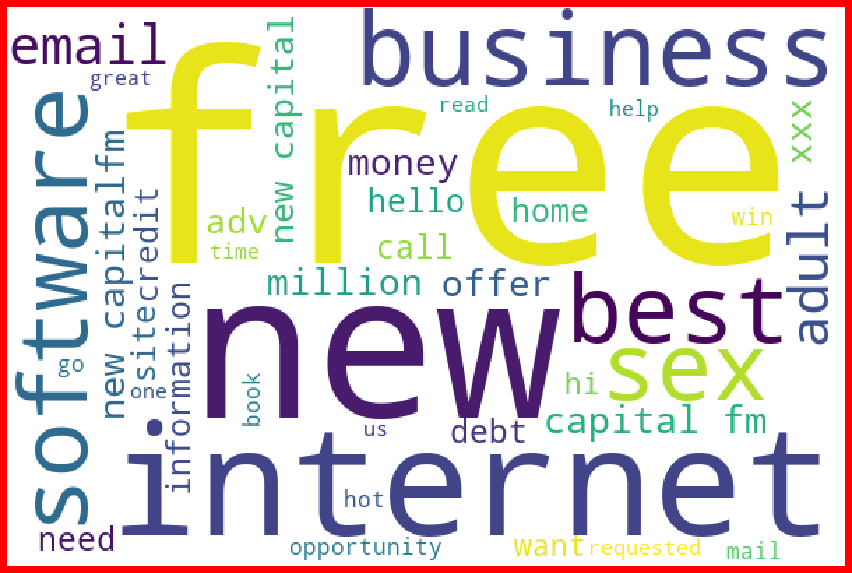

In [21]:
#We see some loud words used for spam message subject
spam_sub=data['subject'][data['label']==1]

spam_sub_cloud=WordCloud(width=600,height=400,background_color='white',max_words=40).generate(' '.join(spam_sub))
plt.figure(figsize=(12,10),facecolor='r')
plt.imshow(spam_sub_cloud)
plt.tight_layout(pad=0)
plt.axis('off')
plt.show()

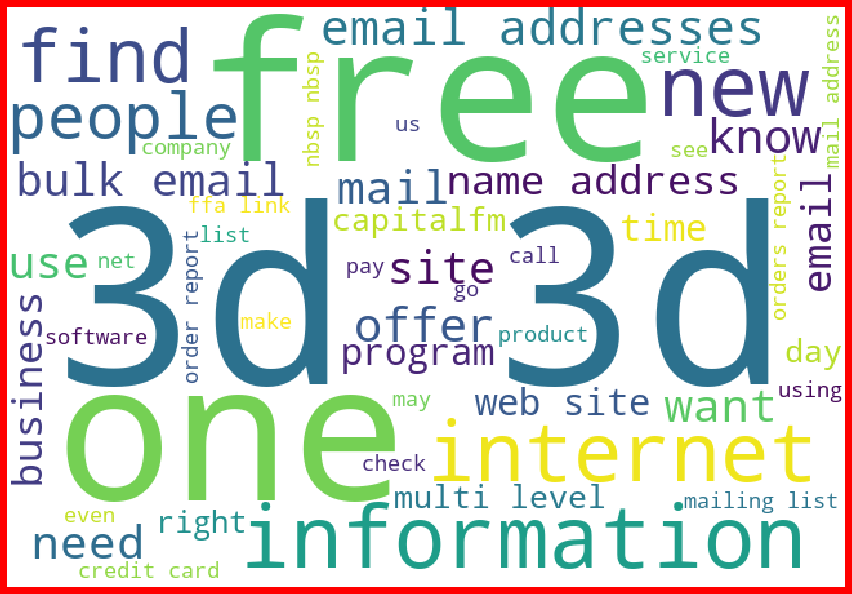

In [22]:
#We see some loud words used for spam message 
spam_msg=data['message'][data['label']==1]

spam_sub_cloud=WordCloud(width=650,height=450,background_color="white",max_words=50).generate(' '.join(spam_msg))
plt.figure(figsize=(12,10),facecolor='r')
plt.imshow(spam_sub_cloud)
plt.tight_layout(pad=0)
plt.axis('off')
plt.show()

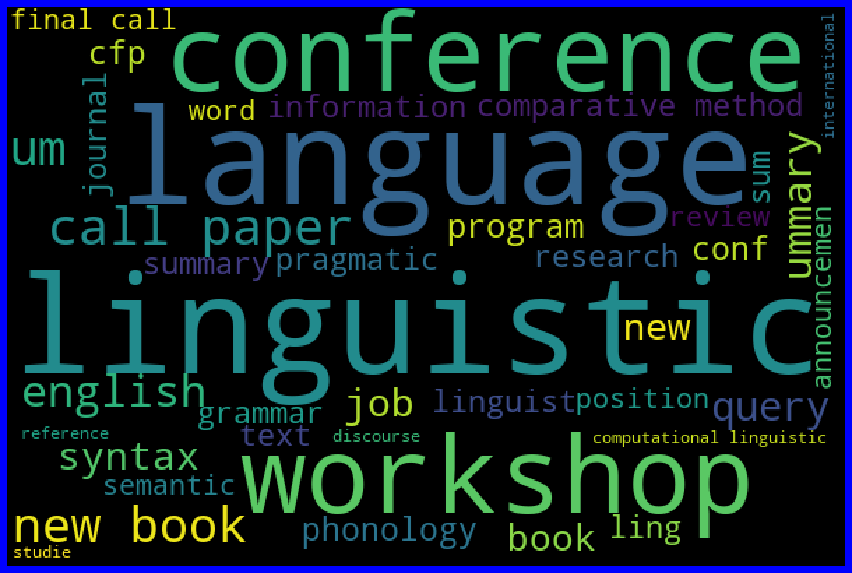

In [23]:
#some Loud words used for ham message subject
ham_sub=data['subject'][data['label']==0]

ham_sub_cloud=WordCloud(width=600,height=400,max_words=40).generate(' '.join(ham_sub))
plt.figure(figsize=(12,10),facecolor='b')
plt.imshow(ham_sub_cloud)
plt.tight_layout(pad=0)
plt.axis('off')
plt.show()

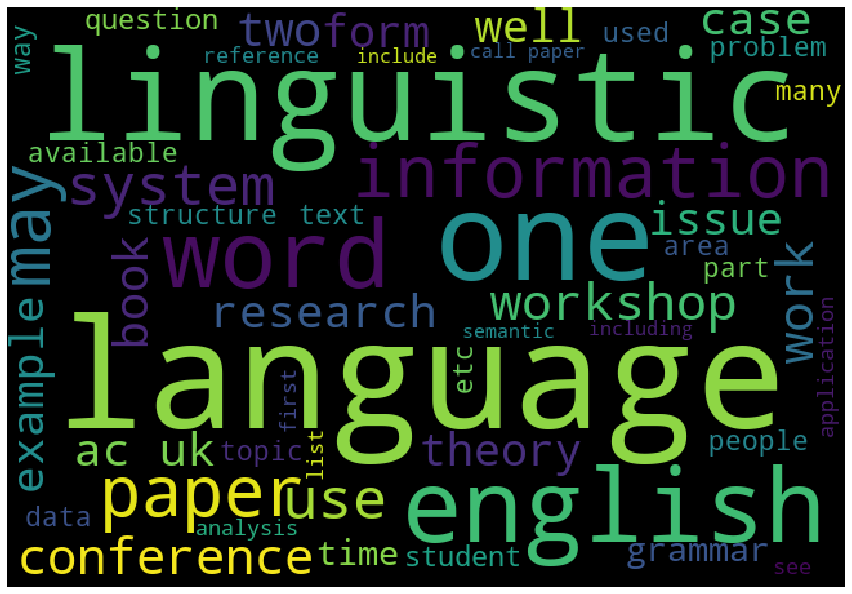

In [24]:
#Some Loud Words used for ham message
ham_msg=data['message'][data['label']==0]

ham_msg_cloud=WordCloud(width=650,height=450,max_words=50).generate(' '.join(ham_msg))
plt.figure(figsize=(12,10))
plt.imshow(ham_msg_cloud)
plt.tight_layout(pad=0)
plt.axis('off')
plt.show()

In [25]:
#The data is cleaned and can be vectorized to perform machine learning
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf=TfidfVectorizer()

x=tfidf.fit_transform(data.message)
y=data['label']

Machine Learning to detect spam emails

In [26]:
#Checking for best random state
max_acc_scr=0
for r_state in range(42,101):
    train_x,test_x,train_y,test_y=train_test_split(x,y,random_state=r_state,test_size=0.25)
    mnb=MultinomialNB()
    mnb.fit(train_x,train_y)
    pred=mnb.predict(test_x)
    acc_scr=accuracy_score(pred,test_y)
    if acc_scr>max_acc_scr:
        max_acc_scr=acc_scr
        final_r_state=r_state
    print('Max Accuracy score corresponding to ',final_r_state,' is ',max_acc_scr)    

Max Accuracy score corresponding to  42  is  0.8328729281767956
Max Accuracy score corresponding to  43  is  0.9019337016574586
Max Accuracy score corresponding to  43  is  0.9019337016574586
Max Accuracy score corresponding to  43  is  0.9019337016574586
Max Accuracy score corresponding to  43  is  0.9019337016574586
Max Accuracy score corresponding to  43  is  0.9019337016574586
Max Accuracy score corresponding to  43  is  0.9019337016574586
Max Accuracy score corresponding to  43  is  0.9019337016574586
Max Accuracy score corresponding to  43  is  0.9019337016574586
Max Accuracy score corresponding to  43  is  0.9019337016574586
Max Accuracy score corresponding to  43  is  0.9019337016574586
Max Accuracy score corresponding to  43  is  0.9019337016574586
Max Accuracy score corresponding to  43  is  0.9019337016574586
Max Accuracy score corresponding to  43  is  0.9019337016574586
Max Accuracy score corresponding to  43  is  0.9019337016574586
Max Accuracy score corresponding to  43 

In [28]:
#Checking fitting of model
score=cross_val_score(mnb,x,y,cv=5)
print("Cross val score: ",score)
print("Mean:",score.mean())

Cross val score:  [0.86206897 0.87564767 0.87543253 0.85294118 0.85986159]
Mean: 0.8651903856057341


In [31]:
#spliting the dataset taking random state= 43
train_x,test_x,train_y,test_y=train_test_split(x,y,random_state=43,test_size=0.25)
#Checking The best model
model=[LogisticRegression(),KNeighborsClassifier(),SVC(),DecisionTreeClassifier()]
for m in model:
    m.fit(train_x,train_y)
    predm=m.predict(test_x)
    print('Model :',m)
    print('Accuracy Score: ',accuracy_score(predm,test_y),"\n")
    print("Confusion Matrix: \n",confusion_matrix(predm,test_y),"\n")
    print('Classification Report: \n',classification_report(predm,test_y))
    print("*****************************************")

Model : LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
Accuracy Score:  0.9682320441988951 

Confusion Matrix: 
 [[619  23]
 [  0  82]] 

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.96      0.98       642
           1       0.78      1.00      0.88        82

    accuracy                           0.97       724
   macro avg       0.89      0.98      0.93       724
weighted avg       0.98      0.97      0.97       724

*****************************************
Model : KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='unifo

In [32]:
#Checking for best model using Ensemble Techniques
model=[RandomForestClassifier(),AdaBoostClassifier(),GradientBoostingClassifier()]
for m in model:
    m.fit(train_x,train_y)
    predm=m.predict(test_x)
    print('Model :',m)
    print('Accuracy Score: ',accuracy_score(predm,test_y),"\n")
    print("Confusion Matrix: \n",confusion_matrix(predm,test_y),"\n")
    print('Classification Report: \n',classification_report(predm,test_y))
    print("*****************************************")

Model : RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Accuracy Score:  0.9585635359116023 

Confusion Matrix: 
 [[617  28]
 [  2  77]] 

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.96      0.98       645
           1       0.73      0.97      0.84        79

    accuracy                           0.96       724
   macro avg       0.87      0.97      0.91       724
weighted avg       0.97      0.96      0.96       724

*****************************************
Model : AdaBoostClassifie

In [37]:
#Among All the models KNeighborsClassifier gives heighest Accuaracy Score,F1_score,precision and recall.
#So we use KNN for classification
#Try to find best parameter using GridSearchCV

knn=KNeighborsClassifier()
grid_param={'n_neighbors':[50,100,150,200,250,300,350,400]}
Gd_sr=GridSearchCV(estimator=knn,param_grid=grid_param,cv=5,scoring='f1')
Gd_sr.fit(train_x,train_y)
best_param=Gd_sr.best_params_
print(best_param)
best_score=Gd_sr.best_score_
print(best_score)

{'n_neighbors': 150}
0.9731363626757726


In [38]:
#Again checking score using scoring='accuracy'
KNN=KNeighborsClassifier()
grid_param={'n_neighbors':[50,100,150,200,250,300,350,400]}
Gd_sr=GridSearchCV(estimator=KNN,param_grid=grid_param,cv=5,scoring='accuracy')
Gd_sr.fit(train_x,train_y)
best_param=Gd_sr.best_params_
print(best_param)
best_score=Gd_sr.best_score_
print(best_score)

{'n_neighbors': 150}
0.9907791609036423


Final Model

In [41]:
knn=KNeighborsClassifier(n_neighbors=150)
knn.fit(train_x,train_y)
Final_pred=knn.predict(test_x)
print("Prediction ",Final_pred)

Prediction  [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 1 0 1 0 0 0 0 1
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1
 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0 0
 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 

In [42]:
#Agin checking metrics
print('Accuracy Score: ',accuracy_score(Final_pred,test_y))
print('Confusion Matrix: \n',confusion_matrix(Final_pred,test_y))
print('Classification Report: \n',classification_report(test_y,Final_pred))

Accuracy Score:  0.9848066298342542
Confusion Matrix: 
 [[617   9]
 [  2  96]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       619
           1       0.98      0.91      0.95       105

    accuracy                           0.98       724
   macro avg       0.98      0.96      0.97       724
weighted avg       0.98      0.98      0.98       724



In [44]:
#Prediction at 8th index
Final_pred[8]

1

In [45]:
#Prediction at 56th index
Final_pred[56]

0

In [46]:
#Saving the Final prediction in csv
df=pd.DataFrame(Final_pred)
df.to_csv('Spam_prediction.csv')

#Saving the Final Model for Production
from sklearn.externals import joblib
joblib.dump(knn,"Spam_prediction.obj")

['Spam_prediction.obj']